In [45]:
import pandas as pd,numpy as np,sklearn
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
tmp1 = pd.read_csv('CB_Nov16_Enrich_02Websites_final_data_dec28.csv')
tmp2 = pd.read_csv('SAAS_Classified_final_data_dec28.csv')
df = pd.concat([tmp1,tmp2],ignore_index=True)

In [16]:
df.shape

(885, 7)

In [7]:
df.ix[df['website_text']=='404 - Object Not Found','website_text'] = ''

In [10]:
df.head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription
0,http://www.ultracartstore.com,False,False,False,0.0,,False
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False
2,http://www.globalmillennials.org,False,False,False,0.0,Global Millennials For Progress Home About Us ...,False
3,http://www.les-artisans-francais.fr,False,False,False,0.0,"Artisans-francais, l'annuaire des professionne...",False
4,http://www.nedboxgroup.com,False,False,False,0.0,Nedboxgroup Ltd. Группа компаний Nedboxgroup L...,False


In [19]:
df = df.drop_duplicates('website')
df.shape

(885, 7)

In [2]:
#text processing
import nltk,re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from text_processing import extract_phrases
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk,re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from text_processing import extract_phrases

In [7]:
grammar = r"""
  NP1: {<JJ><NN.*>+}          # Chunk sequences of JJ, NN
  NP2: {<NN.*>+<JJ>}          # Chunk sequences of NN and JJ
  NP3: {<NN.*>+}                  #Noun phrases
  VP: {<VB.*><NN.*>+} # Chunk verbs and their arguments
  """
phr_list = ['NP1','NP2','NP3','VP']
tag_list = ['NN','NNS','NNP','NNPS','VB','VBD','VBG','VBN','VBP','VBZ']
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to']
cp = nltk.RegexpParser(grammar)
pe = extract_phrases.PhraseExtractor()
snowball_stemmer = SnowballStemmer('english')
wordnet_lemmatizer = WordNetLemmatizer()
reg_exp = re.compile('[^a-zA-Z ]',re.IGNORECASE)
def tokenizer(text,stem_type='lemmatize'):
    pos_tags = nltk.pos_tag(nltk.word_tokenize(text))
    phrs = pe.extract_phrase_treeinput(cp.parse(pos_tags),['NP1','NP2','VP'])
    if stem_type == 'stem':
        wrds = [snowball_stemmer.stem(i[0]) for i in pos_tags if i[1] in tag_list]
    elif stem_type == 'lemmatize':
        wrds = [wordnet_lemmatizer.lemmatize(i[0]) for i in pos_tags if i[1] in tag_list]
    wrds = [wrd for wrd in wrds if wrd.lower() not in stop_words]
    if stem_type == 'stem':
        phrs = ['_'.join([snowball_stemmer.stem(wrd) for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    elif stem_type == 'lemmatize':
        phrs = ['_'.join([wordnet_lemmatizer.lemmatize(wrd) for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    else:
        phrs = ['_'.join([wrd for wrd in nltk.word_tokenize(phr)]) for phr in phrs]
    wrds = [reg_exp.sub('',i) for i in wrds]
    return wrds+phrs

In [27]:
df['website_text_phrases'] = df['website_text'].fillna('').\
    apply(lambda x: ' '.join(tokenizer(unicode(x,'ascii','ignore'))))

In [178]:
df['website_text_stemmed'] = df['website_text'].fillna('').apply(
    lambda x:' '.join([snowball_stemmer.stem(wrd) for wrd in nltk.word_tokenize(x.decode('utf-8','ignore'))]))

In [179]:
df.to_csv('final_data_used_dec28.csv',index=False,quoting=1,encoding='utf-8')

In [21]:
df = pd.read_csv('final_data_used_dec28.csv')
feat_names = pd.read_csv('feature_names_stem.csv')['word']

In [20]:
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to',
                               'using','use','home','get','us']
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.1,stop_words=stop_words)
tfidf = tfidf_vectorizer.fit_transform(df['website_text'].fillna(''))
tfidf.shape

(885, 692)

In [22]:
stop_words = stopwords.words()+['http','https','goo','isnt','wwwfacebookcomtr','wwwgoogletagmanagercomnshtml',
                               'and','be','do','facebook','for','in','is','inc','linkedin','of','the','to',
                               'using','use','home','get','us']
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=0.1,stop_words=stop_words,vocabulary=feat_names)
tfidf = tfidf_vectorizer.fit_transform(df['website_text_stemmed'].fillna(''))
tfidf.shape

(885, 709)

In [23]:
from scipy.sparse import hstack
from scipy.sparse.csr import csr_matrix
tfidf_n_vars = hstack([tfidf,
        csr_matrix(df[['demo_present','login_present','pricing_present']].values.astype(float))])
tfidf_n_vars.shape
# tfidf_n_vars = tfidf

(885, 712)

In [24]:
#new variables (not used currently in the final model)
reg_text = r'(([0-9]|\$|\b|/)per|/)(\b| |\n|\r){0,2}(month|year|\bmo)\b'
df['per_month_present'] = df['website_text'].fillna('').str.contains(reg_text,case=False)
#coming soon
df['coming_soon'] = df['website_text'].fillna('').str.contains(r'coming soon',case=False)

#combining all
tfidf_n_vars = hstack([tfidf,
        csr_matrix(df[['demo_present','login_present','pricing_present','per_month_present','coming_soon']].values.astype(float))])
tfidf_n_vars.shape

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


(885, 714)

In [50]:
df.groupby(['per_month_present','saas_subscription']).size()

per_month_present  saas_subscription
False              False                435
                   True                 306
True               False                 47
                   True                  97
dtype: int64

In [14]:
df[(df['per_month_present'] == True)&(df['saas_subscription'] == False)].head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,per_month_present
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False,Bienvenue toujours jamais Skip content Bienven...,True
5,http://www.pagey.io,False,True,True,8.4,Pagey Features Pricing Our Story Login Promote...,False,Pagey Features Pricing Story Login Promote ser...,True
6,http://www.ninjatoolsuite.net,True,True,True,12.4,Ninja Tool Suite - HOME HOME View Pages DEMO S...,False,Ninja Tool Suite HOME HOME View Pages DEMO SIG...,True
7,http://www.graphicbees.com,False,True,True,11.8,Graphic Bees – Unlimited Graphic Design Guaran...,False,Graphic Bees Unlimited Graphic Design Guarante...,True
15,http://www.eveassist.com,False,False,True,21.6,"EveAssist <div style=""display:inline;""> <img h...",False,EveAssist div style display inline img heig...,True


In [7]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel,RFE

traing predictions
             precision    recall  f1-score   support

      False       0.86      0.80      0.83       482
       True       0.78      0.84      0.81       403

avg / total       0.82      0.82      0.82       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.78      0.69      0.73       482
       True       0.67      0.77      0.72       403

avg / total       0.73      0.72      0.72       885

42.5


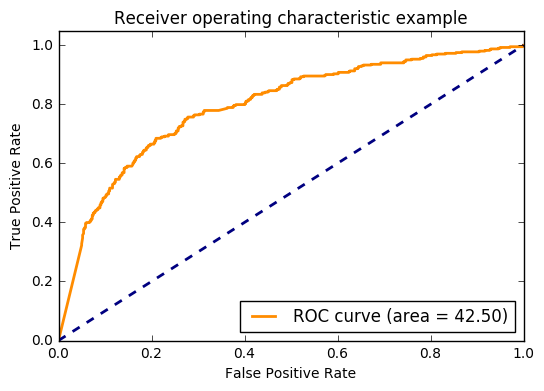

In [50]:
clf = make_pipeline(StandardScaler(with_mean=False),MultinomialNB()) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
cv_pred = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)
print classification_report(df['saas_subscription'],cv_pred)
print auc(df['saas_subscription'],cv_pred)
cv_pred_prob = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]
fpr, tpr, _ = roc_curve(df['saas_subscription'], cv_pred_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(df['saas_subscription'],cv_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
clf = make_pipeline(StandardScaler(with_mean=False),LogisticRegressionCV(Cs=10)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
cv_pred = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)
print classification_report(df['saas_subscription'],cv_pred)
print auc(df['saas_subscription'],cv_pred)
cv_pred_prob = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]
fpr, tpr, _ = roc_curve(df['saas_subscription'], cv_pred_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(df['saas_subscription'],cv_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

traing predictions
             precision    recall  f1-score   support

      False       0.84      0.88      0.86       482
       True       0.85      0.79      0.82       403

avg / total       0.84      0.84      0.84       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.74      0.78      0.76       482
       True       0.72      0.68      0.70       403

avg / total       0.73      0.73      0.73       885

40.0


In [264]:
hidden_layer_sizes=(50,)
alpha = 50
clf = make_pipeline(StandardScaler(with_mean=False),MLPClassifier(hidden_layer_sizes=hidden_layer_sizes,alpha=alpha)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.91      0.85      0.88       482
       True       0.83      0.90      0.87       403

avg / total       0.88      0.87      0.87       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.76      0.77      0.76       482
       True       0.72      0.70      0.71       403

avg / total       0.74      0.74      0.74       885



In [78]:
C = 0.00005
clf = make_pipeline(StandardScaler(with_mean=False),LinearSVC(C=C)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.87      0.82      0.84       482
       True       0.79      0.86      0.82       403

avg / total       0.84      0.83      0.83       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.79      0.71      0.75       482
       True       0.69      0.78      0.73       403

avg / total       0.74      0.74      0.74       885



traing predictions
             precision    recall  f1-score   support

      False       0.87      0.88      0.87       482
       True       0.86      0.84      0.85       403

avg / total       0.86      0.86      0.86       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.78      0.79      0.78       482
       True       0.74      0.74      0.74       403

avg / total       0.76      0.76      0.76       885

42.5


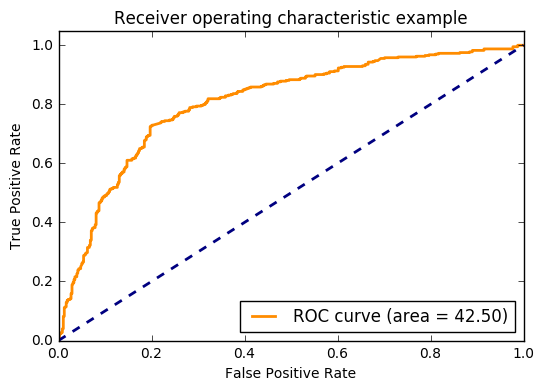

In [48]:
C = 0.00085
clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear',probability=True)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
cv_pred = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)
print classification_report(df['saas_subscription'],cv_pred)
print auc(df['saas_subscription'],cv_pred)
cv_pred_prob = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]
fpr, tpr, _ = roc_curve(df['saas_subscription'], cv_pred_prob)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(df['saas_subscription'],cv_pred))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [42]:
n_estimators = 100
min_samples_split=2
min_samples_leaf=9
max_depth = None
clf = make_pipeline(StandardScaler(with_mean=False),RandomForestClassifier(
    n_estimators=n_estimators,min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,max_depth=max_depth)) 
clf.fit(tfidf_n_vars,df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],clf.predict(tfidf_n_vars))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
                                                     tfidf_n_vars,df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.90      0.97      0.94       482
       True       0.96      0.87      0.92       403

avg / total       0.93      0.93      0.93       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.75      0.78      0.77       482
       True       0.73      0.69      0.71       403

avg / total       0.74      0.74      0.74       885



identifying important features

In [235]:
vocab_list = [0]*len(tfidf_vectorizer.vocabulary_)
for wrd in tfidf_vectorizer.vocabulary_:
    vocab_list[tfidf_vectorizer.vocabulary_[wrd]] = wrd
vocab_list.extend(['demo_present','login_present','pricing_present','per_month_present'])

In [236]:
n_estimators = 100
min_samples_split=2
min_samples_leaf=1
max_depth = None
clf = RandomForestClassifier(
    n_estimators=n_estimators,min_samples_split=min_samples_split,
                            min_samples_leaf=min_samples_leaf,max_depth=max_depth)
clf.fit(tfidf_n_vars,df['saas_subscription'])
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), clf.feature_importances_), vocab_list), 
             reverse=True)[:30]

Features sorted by their score:
[(0.0163, u'demo'), (0.0145, u'tool'), (0.0145, 'demo_present'), (0.0094, u'tim'), (0.0088, u'integr'), (0.0088, u'data'), (0.0082, u'automat'), (0.008, u'manag'), (0.008, u'load'), (0.0077, u'app'), (0.0075, u'term'), (0.0071, u'learn'), (0.007, u'platform'), (0.007, u'featur'), (0.0064, u'blog'), (0.0058, u'process'), (0.0057, u'privaci'), (0.0056, u'game'), (0.0056, u'enjoy'), (0.0055, u'compani'), (0.0054, u'within'), (0.0054, u'mobil'), (0.0051, u'softwar'), (0.0046, u'solut'), (0.0045, u'trial'), (0.0045, u'secur'), (0.0045, u'benefit'), (0.0044, u'team'), (0.0043, u'request'), (0.0042, u'career')]


In [237]:
#using logistic regression
from sklearn.feature_selection import SelectFromModel
clf = LogisticRegressionCV(Cs=10)
sfm = SelectFromModel(clf, threshold=0.05)
sfm.fit(StandardScaler(with_mean=False).fit_transform(tfidf_n_vars),df['saas_subscription'])
# n_features = sfm.transform(X).shape[1]
print sorted(zip(map(lambda x: round(x, 4), sfm.estimator_.coef_[0,:]), vocab_list), 
             reverse=True)[:30]

[(0.1271, 'demo_present'), (0.1142, u'api'), (0.1138, u'prevent'), (0.1075, u'load'), (0.1056, u'demo'), (0.105, u'game'), (0.1029, u'cours'), (0.0982, u'perform'), (0.0958, u'term'), (0.0905, u'feedback'), (0.089, u'data'), (0.0866, u'contain'), (0.0851, u'multipl'), (0.0842, u'annual'), (0.0817, u'purchas'), (0.0816, u'privaci'), (0.0815, u'transact'), (0.081, u'full'), (0.0794, u'mobil'), (0.0778, u'tim'), (0.0769, u'san'), (0.0752, u'field'), (0.0745, u'around'), (0.0736, u'within'), (0.0736, u'user'), (0.0716, u'posit'), (0.071, u'owner'), (0.0687, 'per_month_present'), (0.0686, u'drive'), (0.0684, u'respons')]


In [238]:
#predicted scores
class MNB_Prob_pred(MultinomialNB):
    def predict(self, X):
        return MultinomialNB.predict_proba(self, X)[:,1]
clf = make_pipeline(StandardScaler(with_mean=False),MNB_Prob_pred()) 
nb_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)

In [239]:
#predicted scores
class RF_Prob_pred(RandomForestClassifier):
    def __init__(self, n_estimators=100):
        RandomForestClassifier.__init__(self, n_estimators=100)
    def predict(self, X):
        return RandomForestClassifier.predict_proba(self, X)[:,1]
clf = make_pipeline(StandardScaler(with_mean=False),RF_Prob_pred()) 
rf_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10)

In [240]:
# #predicted scores
# class SVM_Prob_pred():
#     def __init__(self):
#         self.svc = SVC(C=0.002,probability=True,kernel='linear')
# #         SVC.__init__(self, C=0.002,probability=True,kernel='linear')
#     def fit(X,y):
#         self.svc.fit(X,y)
#     def predict(self, X):
#         return self.svc.predict_proba(self, X)[:,1]
#     def get_params(self,**kwargs):
#         self.svc.get_params(**kwargs)
#     def set_params(self,**params):
#         self.svc.set_params(**params)
clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=0.001,probability=True,kernel='linear'))
svm_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]

In [241]:
clf = make_pipeline(StandardScaler(with_mean=False),LogisticRegressionCV(Cs=10))
logistic_preds = cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1]

In [242]:
df.shape,nb_preds.shape,rf_preds.shape,logistic_preds.shape

((885, 15), (885,), (885,), (885,))

In [243]:
df['naive_bayes_predictions'] = nb_preds
df['random_forest_prediction'] = rf_preds
df['linear_svm_prediction'] = svm_preds
df['logistic_prediction'] = logistic_preds
df.head()

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,website_text_stemmed,per_month_present,coming_soon,naive_bayes_predictions,random_forest_prediction,linear_svm_prediction,logistic_prediction
0,http://www.ultracartstore.com,False,False,False,0.0,NaN,False,NaN,,False,False,4.553459e-01,0.164677,0.150420,0.269833
1,http://www.borathyun.wordpress.com,True,True,True,41.0,Bienvenue – toujours de l'avant et plus déterm...,False,Bienvenue toujours jamais Skip content Bienven...,bienvenu – toujour de l'avant et plus détermin...,True,False,2.258689e-31,0.500000,0.174478,0.311809
2,http://www.globalmillennials.org,False,False,False,0.0,Global Millennials For Progress Home About Us ...,False,Millennials Progress Home Us Team Contribute T...,global millenni for progress home about us our...,False,True,1.079722e-08,0.430000,0.345552,0.392669
3,http://www.les-artisans-francais.fr,False,False,False,0.0,"Artisans-francais, l'annuaire des professionne...",False,Artisansfrancais lannuaire professionnels part...,"artisans-francai , l'annuair des professionnel...",False,False,2.851695e-22,0.412676,0.062182,0.235249
4,http://www.nedboxgroup.com,False,False,False,0.0,Nedboxgroup Ltd. Группа компаний Nedboxgroup L...,False,Nedboxgroup Ltd Nedboxgroup Ltd email info n...,nedboxgroup ltd. группа компаний nedboxgroup l...,False,False,5.223478e-04,0.399614,0.141615,0.321304


In [244]:
df[['website','demo_present','login_present','pricing_present','per_month_present','coming_soon','score',
    'saas_subscription','naive_bayes_predictions','random_forest_prediction','linear_svm_prediction','logistic_prediction']].to_excel(
        'final_data_predicted_scores_jan2_stem.xls',index=False)

In [245]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

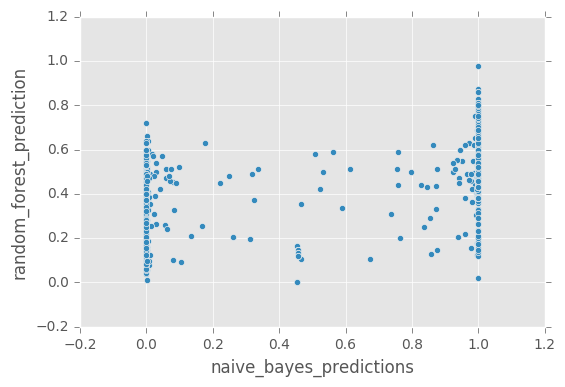

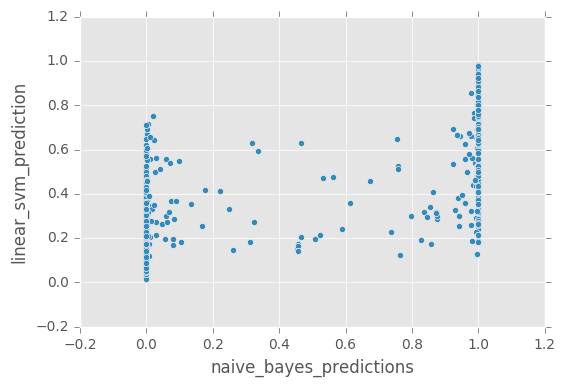

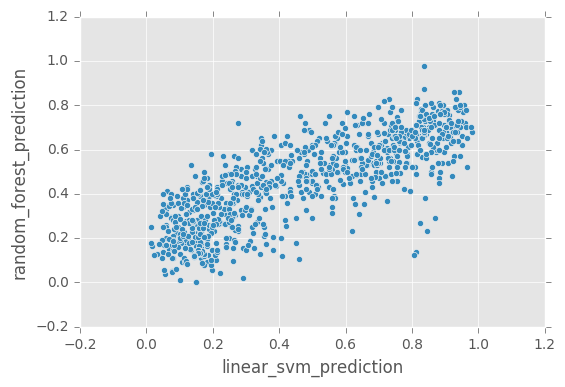

In [246]:
df.plot.scatter(x='naive_bayes_predictions',y='random_forest_prediction')
df.plot.scatter(x='naive_bayes_predictions',y='linear_svm_prediction')
df.plot.scatter(x='linear_svm_prediction',y='random_forest_prediction')
plt.show()

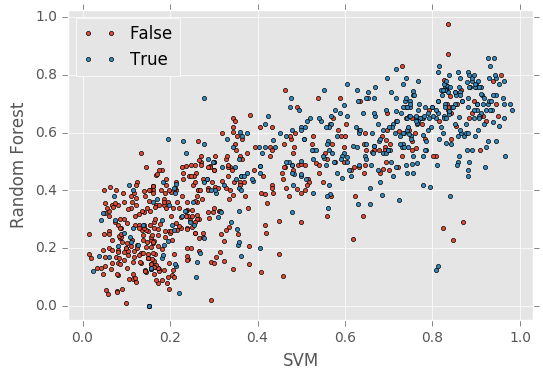

In [247]:
groups = df.groupby('saas_subscription')
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group.linear_svm_prediction, group.random_forest_prediction, marker='o', linestyle='', ms=3, label=name,
           )
ax.legend(loc='upper left')
ax.set_xlabel("SVM")
ax.set_ylabel("Random Forest")
plt.show()

In [248]:
#stacking using logistic regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegressionCV(Cs=10)
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.78      0.77      0.78       482
       True       0.73      0.74      0.74       403

avg / total       0.76      0.76      0.76       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.78      0.74      0.76       482
       True       0.71      0.75      0.73       403

avg / total       0.75      0.74      0.75       885



In [249]:
#stacking using random forest
clf = RandomForestClassifier(n_estimators=200)
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.99      0.98      0.99       482
       True       0.98      0.99      0.98       403

avg / total       0.99      0.99      0.99       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.72      0.74      0.73       482
       True       0.68      0.66      0.67       403

avg / total       0.70      0.70      0.70       885



In [250]:
#stacking using svm
C=0.1
clf = SVC(C=C,kernel='linear')
clf.fit(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'])
print 'traing predictions'
print classification_report(df['saas_subscription'],
                clf.predict(df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']]))
print 'cross-validation predictions'
print classification_report(df['saas_subscription'],cross_val_predict(clf,
        df[['naive_bayes_predictions','random_forest_prediction','linear_svm_prediction']],df['saas_subscription'],cv=10))

traing predictions
             precision    recall  f1-score   support

      False       0.80      0.70      0.74       482
       True       0.69      0.79      0.73       403

avg / total       0.75      0.74      0.74       885

cross-validation predictions
             precision    recall  f1-score   support

      False       0.79      0.70      0.74       482
       True       0.68      0.78      0.73       403

avg / total       0.74      0.74      0.74       885



In [251]:
#majority voting
def get_majority_pred(pred1,pred2,pred3):
    pred1_class,pred2_class,pred3_class = pred1>0.5,pred2>0.5,pred3>0.5
    if (pred1_class and pred2_class) or (pred1_class and pred3_class) or (pred2_class and pred3_class):
        return True
    else:
        return False
# df.apply(lambda row: 
#          get_majority_pred(row['naive_bayes_predictions'],row['random_forest_prediction'],row['linear_svm_prediction']))

In [252]:
# majority voting
print classification_report(df['saas_subscription'],
                            ((df['naive_bayes_predictions']>0.5) & (df['random_forest_prediction']>0.5))|\
                            ((df['linear_svm_prediction']>0.5) & (df['random_forest_prediction']>0.5))|\
                            ((df['naive_bayes_predictions']>0.5) & (df['linear_svm_prediction']>0.5)))

             precision    recall  f1-score   support

      False       0.78      0.77      0.78       482
       True       0.73      0.74      0.74       403

avg / total       0.76      0.76      0.76       885



In [253]:
# any true voting
print classification_report(df['saas_subscription'],
       (df['naive_bayes_predictions']>0.5) | (df['random_forest_prediction']>0.5)|(df['linear_svm_prediction']>0.5))

             precision    recall  f1-score   support

      False       0.84      0.63      0.72       482
       True       0.66      0.86      0.74       403

avg / total       0.76      0.73      0.73       885



In [325]:
print 'True,nb pred<0.1: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.1)].shape)
print 'True,nb pred<0.2: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.2)].shape)
print 'True,nb pred<0.4: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']<0.4)].shape)
print 'False,nb pred>0.9: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.9)].shape)
print 'False,nb pred>0.8: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.8)].shape)
print 'False,nb pred>0.6: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']>0.6)].shape)
print 'False,nb pred<0.2: {}'.format(df[(df['saas_subscription']==False) &(df['naive_bayes_predictions']<0.1)].shape)
print 'True,nb pred>0.8: {}'.format(df[(df['saas_subscription']==True) &(df['naive_bayes_predictions']>0.8)].shape)

True,nb pred<0.1: (76, 11)
True,nb pred<0.2: (79, 11)
True,nb pred<0.4: (86, 11)
False,nb pred>0.9: (128, 11)
False,nb pred>0.8: (133, 11)
False,nb pred>0.6: (137, 11)
False,nb pred<0.2: (297, 11)
True,nb pred>0.8: (302, 11)


In [326]:
print 'True,svm pred<0.1: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.1)].shape)
print 'True,svm pred<0.2: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.2)].shape)
print 'True,svm pred<0.4: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']<0.4)].shape)
print 'False,svm pred>0.9: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.9)].shape)
print 'False,svm pred>0.8: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.8)].shape)
print 'False,svm pred>0.6: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']>0.6)].shape)
print 'False,svm pred<0.2: {}'.format(df[(df['saas_subscription']==False) &(df['linear_svm_prediction']<0.2)].shape)
print 'True,svm pred>0.8: {}'.format(df[(df['saas_subscription']==True) &(df['linear_svm_prediction']>0.8)].shape)

True,svm pred<0.1: (5, 11)
True,svm pred<0.2: (38, 11)
True,svm pred<0.4: (79, 11)
False,svm pred>0.9: (8, 11)
False,svm pred>0.8: (29, 11)
False,svm pred>0.6: (80, 11)
False,svm pred<0.2: (176, 11)
True,svm pred>0.8: (106, 11)


In [119]:
def ks_statistic(score,dv):
    ''' assumes 1 as good and 0 as bad'''
    data = pd.DataFrame({'score':score,'dv':dv})
    data['good'] = data['dv']
    data['bad'] = 1-data['good']
    # data['bucket'] = pd.qcut(data.score, 10) #causing error
    bins = pd.core.algorithms.quantile(np.unique(data['score']), np.linspace(0, 1, 11))
    data['bucket'] = pd.tools.tile._bins_to_cuts(data['score'], bins, include_lowest=True)
    grouped = data.groupby('bucket', as_index = False)
    agg1 = pd.DataFrame({'min_scr':grouped.min().score})
    agg1['max_scr'] = grouped.max().score
    agg1['goods'] = grouped.sum().good
    agg1['bads'] = grouped.sum().bad
    agg1['total'] = agg1.bads + agg1.goods
    agg2 = (agg1.sort_index(by = 'min_scr')).reset_index(drop = True)
    agg2['odds'] = (agg2.goods / agg2.bads).apply('{0:.2f}'.format)
    agg2['bad_rate'] = (agg2.bads / agg2.total).apply('{0:.2%}'.format)
    agg2['ks'] = np.round(((agg2.bads / data.bad.sum()).cumsum() - (agg2.goods / data.good.sum()).cumsum()), 4) * 100
    flag = lambda x: '<----' if x == agg2.ks.max() else ''
    agg2['max_ks'] = agg2.ks.apply(flag)
    return agg2

In [254]:
ks_statistic(df['naive_bayes_predictions'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,1.139993e-47,4.605852e-19,10.0,57,67.0,0.18,85.07%,9.34,
1,4.730440e-19,3.063629e-13,9.0,57,66.0,0.16,86.36%,18.94,
2,3.348004e-13,1.680206e-09,13.0,53,66.0,0.25,80.30%,26.71,
3,1.975444e-09,1.179233e-06,12.0,58,70.0,0.21,82.86%,35.76,
4,1.391534e-06,1.832299e-03,19.0,47,66.0,0.40,71.21%,40.80,
5,2.005382e-03,6.129896e-01,25.0,64,89.0,0.39,71.91%,47.87,<----
6,6.739523e-01,9.988775e-01,32.0,37,69.0,0.86,53.62%,47.61,
7,9.989057e-01,9.999988e-01,40.0,27,67.0,1.48,40.30%,43.29,
8,9.999990e-01,1.000000e+00,38.0,29,67.0,1.31,43.28%,39.87,
9,1.000000e+00,1.000000e+00,205.0,53,258.0,3.87,20.54%,0.00,


In [255]:
ks_statistic(df['linear_svm_prediction'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,0.015285,0.115147,13.0,73,86.0,0.18,84.88%,11.92,
1,0.115381,0.171029,10.0,93,103.0,0.11,90.29%,28.73,
2,0.172064,0.239572,20.0,67,87.0,0.30,77.01%,37.67,
3,0.239751,0.319352,19.0,66,85.0,0.29,77.65%,46.65,
4,0.319671,0.433676,31.0,55,86.0,0.56,63.95%,50.37,<----
5,0.433747,0.570492,49.0,43,92.0,1.14,46.74%,47.13,
6,0.570678,0.694060,54.0,33,87.0,1.64,37.93%,40.58,
7,0.696394,0.779188,68.0,18,86.0,3.78,20.93%,27.44,
8,0.779924,0.863435,66.0,21,87.0,3.14,24.14%,15.42,
9,0.863758,0.981533,73.0,13,86.0,5.62,15.12%,0.00,


In [256]:
#0.0003
clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=0.0003,probability=True,kernel='linear'))
ks_statistic(cross_val_predict(clf,tfidf_n_vars,df['saas_subscription'],cv=10,method='predict_proba')[:,1],
             df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,0.040263,0.128847,12.0,78,90.0,0.15,86.67%,13.20,
1,0.128999,0.181748,13.0,88,101.0,0.15,87.13%,28.24,
2,0.182313,0.239054,19.0,66,85.0,0.29,77.65%,37.21,
3,0.239158,0.346182,20.0,65,85.0,0.31,76.47%,45.74,
4,0.347518,0.458431,30.0,57,87.0,0.53,65.52%,50.12,<----
5,0.458975,0.595255,46.0,48,94.0,0.96,51.06%,48.66,
6,0.595292,0.706430,56.0,30,86.0,1.87,34.88%,40.99,
7,0.707329,0.789604,66.0,21,87.0,3.14,24.14%,28.97,
8,0.793494,0.870330,66.0,19,85.0,3.47,22.35%,16.54,
9,0.870334,0.983829,75.0,10,85.0,7.50,11.76%,0.00,


In [257]:
ks_statistic(df['random_forest_prediction'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,0.000000,0.126315,7.0,37,44.0,0.19,84.09%,5.94,
1,0.127834,0.168008,8.0,42,50.0,0.19,84.00%,12.67,
2,0.168692,0.210000,7.0,36,43.0,0.19,83.72%,18.40,
3,0.210555,0.261500,8.0,42,50.0,0.19,84.00%,25.13,
4,0.262256,0.307797,12.0,39,51.0,0.31,76.47%,30.24,
5,0.310000,0.380000,16.0,62,78.0,0.26,79.49%,39.13,
6,0.381842,0.441429,28.0,62,90.0,0.45,68.89%,45.05,<----
7,0.442222,0.530235,63.0,71,134.0,0.89,52.99%,44.15,
8,0.532414,0.660000,127.0,64,191.0,1.98,33.51%,25.91,
9,0.661667,0.977143,127.0,27,154.0,4.70,17.53%,-0.00,


In [258]:
ks_statistic(df['logistic_prediction'],df['saas_subscription'])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,min_scr,max_scr,goods,bads,total,odds,bad_rate,ks,max_ks
0,0.008877,0.202647,12.0,77,89.0,0.16,86.52%,13.00,
1,0.204396,0.262079,9.0,81,90.0,0.11,90.00%,27.57,
2,0.262418,0.310021,22.0,77,99.0,0.29,77.78%,38.09,
3,0.311354,0.381606,19.0,67,86.0,0.28,77.91%,47.27,
4,0.382535,0.461577,34.0,52,86.0,0.65,60.47%,49.62,<----
5,0.461610,0.531089,50.0,38,88.0,1.32,43.18%,45.10,
6,0.531156,0.603254,51.0,37,88.0,1.38,42.05%,40.12,
7,0.604588,0.684441,61.0,26,87.0,2.35,29.89%,30.38,
8,0.684509,0.782735,68.0,18,86.0,3.78,20.93%,17.24,
9,0.783207,0.976260,77.0,9,86.0,8.56,10.47%,0.00,


In [21]:
#going with svm
#tfidf_vectorizer
C = 0.001
svm_model = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear',probability=True)) 
svm_model.fit(tfidf_n_vars,df['saas_subscription'])

Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=False, with_std=True)), ('svc', SVC(C=0.001, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [ ]:
ks_dets = ks_statistic(df['linear_svm_prediction'],df['saas_subscription'])

In [35]:
bin_boundaries = [0]+list(ks_dets['max_scr'])[:-1]+[1]
bin_labels = range(10)
pd.cut(df['linear_svm_prediction'], bin_boundaries,labels=bin_labels).head()

0    1
1    2
2    1
3    0
4    4
Name: linear_svm_prediction, dtype: category
Categories (10, int64): [0 < 1 < 2 < 3 ... 6 < 7 < 8 < 9]

In [36]:
pd.cut(df['linear_svm_prediction'], bin_boundaries,labels=bin_labels).value_counts()

1    102
5     94
2     91
8     86
7     86
6     86
9     85
4     85
3     85
0     85
Name: linear_svm_prediction, dtype: int64

In [68]:
df[df['website'].str.contains('triumphcoffeelab.com')]

,website,demo_present,login_present,pricing_present,score,website_text,saas_subscription,website_text_phrases,naive_bayes_predictions,random_forest_prediction,linear_svm_prediction,per_month_present
293,http://www.triumphcoffeelab.com,False,False,False,0.9,Triumph Coffee Lab Triumph Coffee Lab Our Stor...,False,Triumph Coffee Lab Triumph Coffee Lab Story Wh...,5.010761e-26,0.263478,0.123807,False


In [38]:
import pickle
with open('chargebee_model_objects.pkl','w') as f:
    pickle.dump({'vectorizer':tfidf_vectorizer,'model':svm_model,'bin_boundaries':bin_boundaries,
                'bin_labels':bin_labels},f)

### plotting learning curves

In [28]:
from learning_curves import plot_learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

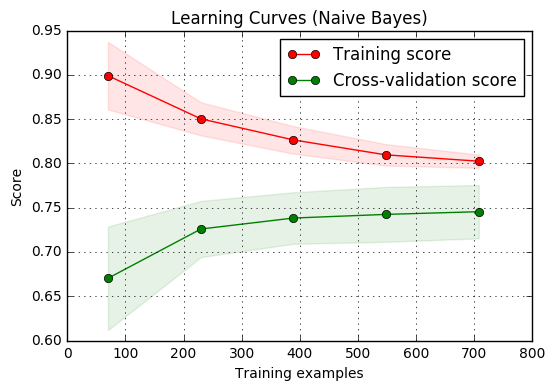

In [42]:
title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = MultinomialNB()
plot_learning_curve(estimator, title, tfidf_n_vars, df['saas_subscription'], cv=cv, n_jobs=4)
plt.show()

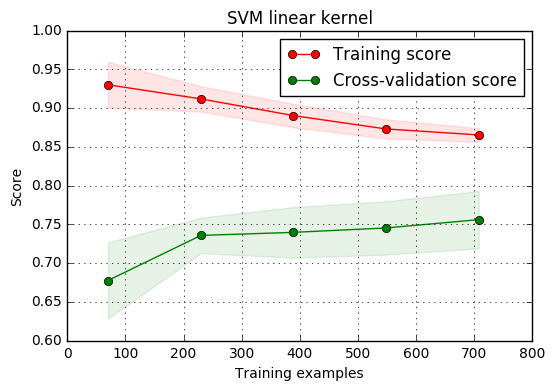

In [43]:
title = "Learning Curves (SVM)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = make_pipeline(StandardScaler(with_mean=False),SVC(C = 0.001,kernel='linear'))
# plot_learning_curve(estimator, title, X, y, (0.7, 1.01), cv=cv, n_jobs=4)
plot_learning_curve(estimator=estimator,
                         title='SVM linear kernel',X=tfidf_n_vars,y=df['saas_subscription'],cv=cv)

plt.show()

### looking at misclassified items

In [48]:
#trying in excel
df[['website','demo_present','login_present','pricing_present','score',
    'saas_subscription','naive_bayes_predictions','random_forest_prediction','linear_svm_prediction','website_text_phrases']].to_csv(
        'final_data_predicted_scores_dec29.csv',index=False,quoting=1)

### validation curve

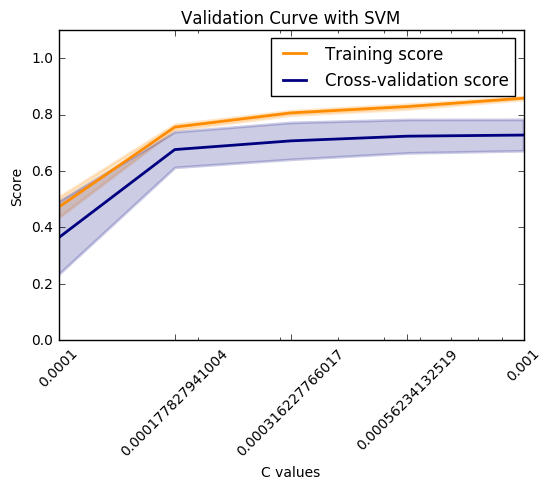

In [30]:
from sklearn.model_selection import validation_curve
param_range = np.logspace(-4, -3, 5)
# param_range = np.arange(0.0001,0.0006,0.00001)
# clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear'))
#                     tfidf_n_vars,df['saas_subscription']
train_scores, test_scores = validation_curve(
    SVC(kernel='linear'), StandardScaler(with_mean=False).fit_transform(tfidf_n_vars),
    df['saas_subscription'], param_name="C", param_range=param_range,
    cv=10, scoring="f1", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel("C values")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
# plt.plot(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.plot(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)
#plotting the actual points(not working)
# for xy in zip(param_range, train_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 
# for xy in zip(param_range, test_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 

plt.xticks(param_range, param_range,rotation=45)
plt.legend(loc="best")
plt.show()


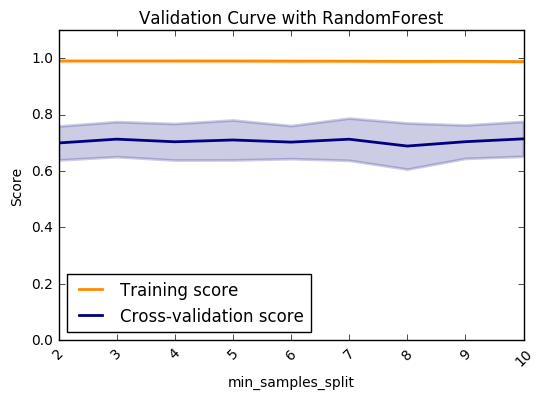

In [43]:
from sklearn.model_selection import validation_curve
# param_range = np.logspace(-4, -3, 5)
param_range = np.arange(2,11)
# clf = make_pipeline(StandardScaler(with_mean=False),SVC(C=C,kernel='linear'))
#                     tfidf_n_vars,df['saas_subscription']
train_scores, test_scores = validation_curve(
    RandomForestClassifier(n_estimators=100), StandardScaler(with_mean=False).fit_transform(tfidf_n_vars),
    df['saas_subscription'], param_name="min_samples_split", param_range=param_range,
    cv=10, scoring="f1", n_jobs=1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel("min_samples_split")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
# plt.semilogx(param_range, train_scores_mean, label="Training score",
#              color="darkorange", lw=lw)
# plt.fill_between(param_range, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.2,
#                  color="darkorange", lw=lw)
# plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
#              color="navy", lw=lw)
# plt.fill_between(param_range, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.2,
#                  color="navy", lw=lw)

plt.plot(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)

#plotting the actual points(not working)
# for xy in zip(param_range, train_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 
# for xy in zip(param_range, test_scores_mean):                                       
#     plt.annotate('{}'.format(round(x,5)),xy=xy, textcoords='data') 

plt.xticks(param_range, param_range,rotation=45)
plt.legend(loc="best")
plt.show()


In [200]:
pd.DataFrame({'param_value':param_range, 'train_score':train_scores_mean,'test_score':test_scores_mean})

,param_value,test_score,train_score
0,0.000100,0.447081,0.554571
1,0.000167,0.666101,0.758568
2,0.000278,0.717568,0.806471
3,0.000464,0.713540,0.825668
4,0.000774,0.736147,0.852058
5,0.001292,0.720906,0.880277
6,0.002154,0.705285,0.909952
7,0.003594,0.705058,0.937303
8,0.005995,0.694845,0.959115
9,0.010000,0.655717,0.971286


### try stacking using brew package

In [9]:
import brew
from brew.base import Ensemble
from brew.combination.combiner import Combiner
from brew.stacking.stacker import EnsembleStack
from brew.stacking.stacker import EnsembleStackClassifier

layer_1 = [SVC(probability=True,C=0.00035),
           RandomForestClassifier(n_estimators=100), 
           MultinomialNB(),
           MLPClassifier(hidden_layer_sizes=(50,),alpha=50)
           ]

layer_2 = [SVC(probability=True), LogisticRegressionCV(max_iter=500,Cs=10)]

stack = EnsembleStack(cv=10) # number of folds per layer
stack.add_layer(Ensemble(layer_1))
stack.add_layer(Ensemble(layer_2))

clf = EnsembleStackClassifier(stack, Combiner('mean'))

In [10]:
clf.fit(tfidf_n_vars,df['saas_subscription'])

TypeError: only integer arrays with one element can be converted to an index

In [20]:
pd.DataFrame(tfidf_vectorizer.vocabulary_.keys(),columns=['word']).sort('word').to_csv('feature_names.csv',index=False)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
